In [87]:
__version__ = "1.3.0" # data version of csv files

# library imports
import seaborn
import math
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from pathlib import Path
from csv import reader
from IPython.display import HTML, display
import tabulate
import seaborn as sns
from itertools import chain, product
from scipy.stats import poisson, skellam
import numpy as np

def custom_poisson(actual, mean):
    return math.pow(mean, actual) * math.exp(-mean) / math.factorial(actual)

In [2]:
headers = ['ball', 'innings', 'team', 'batsman', 'batsman_two', 'bowler', 'runs', 'extras', 'out', 'player_out']
home_grounds = {
    'Adelaide Strikers': 'Karen Rolton Oval',
    'Brisbane Heat': 'Allan Border Field',
    'Hobart Hurricanes': 'Bellerive Oval',
    'Melbourne Renegades': 'Junction Oval',
    'Melbourne Stars': 'Junction Oval',
    'Perth Scorchers': 'Lilac Hill Park',
    'Sydney Sixers': 'North Sydney Oval',
    'Sydney Thunder': 'Blacktown International Sportspark'
}

In [3]:
def iter_csvs():
    return list(Path('./data/').rglob('*.csv'))

local_csvs = iter_csvs()

In [4]:
def ingest_csv(csv_path_obj):
    with open(str(csv_path_obj), 'r') as fh:
        data = [l.split(',') for l in fh.read().split('\n') if l]
    info, balls = {}, []
    for line in data:
        if line[0] == 'version':
            assert line[1] == __version__
        elif line[0] == 'info':
            if line[1] in info.keys():
                info[f'{line[1]}_two'] = line[2]
            else:
                info[line[1]] = line[2]
        elif line[0] == 'ball':
            ball = dict(zip(headers, [l.replace('"', '') for l in line[1:]]))
            balls.append(ball)
    info['balls'] = balls
    return info

def ingest_csvs(csvs):
    return [ingest_csv(csv) for csv in csvs]

entire_data = ingest_csvs(local_csvs)
latest_season = sorted(list(set([e['season'].strip() for e in entire_data])))[-1]

In [5]:
teams = set([m['team'] for m in entire_data])
away_gamecount, home_gamecount = {t: 0 for t in teams}, {t: 0 for t in teams}
away_runs, home_runs = {t: [] for t in teams}, {t: [] for t in teams}
away_runs_lost, home_runs_lost = {t: [] for t in teams}, {t: [] for t in teams}
away_wickets, home_wickets = {t: [] for t in teams}, {t: [] for t in teams}
away_wickets_lost, home_wickets_lost = {t: [] for t in teams}, {t: [] for t in teams}
#score_data = {t: [] for t in teams}
#concessions = {t: [] for t in teams}
#game_count = {t: 0 for t in teams}

In [9]:
for game in entire_data:
    a, b = game['team'], game['team_two']
    v, s = game['venue'], game['season']
    if s != latest_season:

        runs = [
            sum([int(x['runs']) for x in game['balls'] if x['team']==a]),
            sum([int(x['runs']) for x in game['balls'] if x['team']==b])
        ]
        wickets = [
            sum([int(bool(x['player_out'])) for x in game['balls'] if x['team']==a]),
            sum([int(bool(x['player_out'])) for x in game['balls'] if x['team']==b])
        ]
        for t in [0,1]:
            team = [a,b][t]
            if v in home_grounds.get(team):
                home_runs[team].append(runs[t])
                home_runs_lost[team].append(runs[t-1])
                home_wickets[team].append(wickets[t])
                home_wickets_lost[team].append(wickets[t-1])
                home_gamecount[team] += 1
            elif v not in home_grounds.get(team):
                away_runs[team].append(runs[t])
                away_runs_lost[team].append(runs[t-1])
                away_wickets[team].append(wickets[t])
                away_wickets_lost[team].append(wickets[t-1])
                away_gamecount[team] += 1
        #score_data[a].append(set_a)
        #score_data[b].append(set_b)
        #concessions[a].append(set_b)
        ##concessions[b].append(set_a)
        #game_count[a] += 1
        #game_count[b] += 1

In [14]:
home_run_avg = {k: mean(v) for k, v in home_runs.items()}
away_run_avg = {k: mean(v) for k, v in away_runs.items()}
home_league_run_avg = mean([v for k, v in home_run_avg.items()])
away_league_run_avg = mean([v for k, v in away_run_avg.items()])

home_run_lost_avg = {k: mean(v) for k, v in home_runs_lost.items()}
away_run_lost_avg = {k: mean(v) for k, v in away_runs_lost.items()}
home_league_run_lost_avg = mean([v for k, v in home_run_lost_avg.items()])
away_league_run_lost_avg = mean([v for k, v in away_run_lost_avg.items()])

home_wicket_avg = {k: mean(v) for k, v in home_wickets.items()}
away_wicket_avg = {k: mean(v) for k, v in away_wickets.items()}
home_league_wicket_avg = mean([v for k, v in home_wicket_avg.items()])
away_league_wicket_avg = mean([v for k, v in away_wicket_avg.items()])

home_wicket_lost_avg = {k: mean(v) for k, v in home_wickets_lost.items()}
away_wicket_lost_avg = {k: mean(v) for k, v in away_wickets_lost.items()}
home_league_wicket_lost_avg = mean([v for k, v in home_wicket_lost_avg.items()])
away_league_wicket_lost_avg = mean([v for k, v in away_wicket_lost_avg.items()])

#run_avg = {k: sum(v)/len(v) for k, v in score_data.items()}
#concession_avg = {k: sum(v)/len(v) for k, v in concessions.items()}
#league_run_avg = [v for k, v in run_avg.items()]
##league_run_avg = sum(league_run_avg) / len(league_run_avg)
#league_con_avg = [v for k, v in concession_avg.items()]
#league_con_avg = sum(league_con_avg) / len(league_con_avg)
#league_con_avg
away_league_run_avg, away_league_wicket_avg, home_league_run_avg, home_league_wicket_avg

(119.8375911137615, 6.064222000631661, 134.84583333333333, 5.367261904761905)

In [13]:
home_gamecount, away_gamecount

({'Adelaide Strikers': 3,
  'Perth Scorchers': 6,
  'Melbourne Stars': 1,
  'Sydney Thunder': 2,
  'Hobart Hurricanes': 12,
  'Brisbane Heat': 5,
  'Sydney Sixers': 7,
  'Melbourne Renegades': 3},
 {'Adelaide Strikers': 35,
  'Perth Scorchers': 36,
  'Melbourne Stars': 41,
  'Sydney Thunder': 32,
  'Hobart Hurricanes': 25,
  'Brisbane Heat': 34,
  'Sydney Sixers': 38,
  'Melbourne Renegades': 34})

In [85]:
def get_home_offence(t):
    return sum(home_runs[t]) / home_gamecount[t] / home_league_run_avg
def get_away_defence(a):
    return sum(away_runs_lost[a]) / away_gamecount[a] / away_league_run_lost_avg
def get_exp_home_runs(o, d):
    return o * d * home_league_run_avg
def get_away_offence(a):
    return sum(away_runs[a]) / away_gamecount[a] / away_league_run_avg
def get_home_defence(h):
    return sum(home_runs_lost[h]) / home_gamecount[h] / home_league_run_lost_avg

def get_predicted_scores(h, a):
    # runs scored at home / number home games / home league average
    home_offence = get_home_offence(h)
    away_defence = get_away_defence(a)
    home_team_runs = home_offence * away_defence * home_league_run_avg

    away_offence = sum(away_runs[a]) / away_gamecount[a] / away_league_run_avg
    home_defence = sum(home_runs_lost[h]) / home_gamecount[h] / home_league_run_lost_avg
    away_team_runs = away_offence * home_defence * away_league_run_avg

    return home_team_runs, away_team_runs

print(get_predicted_scores('Melbourne Stars', 'Hobart Hurricanes'))
print(get_predicted_scores('Hobart Hurricanes', 'Melbourne Stars'))
print(get_predicted_scores('Hobart Hurricanes', 'Brisbane Heat'))
print(get_predicted_scores('Brisbane Heat', 'Hobart Hurricanes'))
print(get_predicted_scores('Melbourne Stars', 'Brisbane Heat'))
print(get_predicted_scores('Brisbane Heat', 'Melbourne Stars'))

# calculate the defensive strength of a team (regardless of playing away/home) as the conceded run average of the team divided by the league concession average.
#defense_strength = {k: concession_avg[k]/league_con_avg for k, v in concession_avg.items()}
# inversely, calculate the strength as the team run average divided by the league run average (again irrespective of playing at home or not)
#offense_strength = {k: run_avg[k]/league_run_avg for k, v in run_avg.items()}
# let's see what that looks like
#print('Melbourne Stars', defense_strength['Melbourne Stars'], offense_strength['Melbourne Stars'])

(165.38675688456115, 148.74880336178987)
(120.07817853998934, 116.57716069731246)
(123.55476410951954, 134.23343554092529)
(115.13462690809834, 106.68226279323274)
(155.8588399009573, 156.39814011076265)
(105.44870773134373, 97.41438437489708)


In [11]:
# Let's find some expected scores!
# Take the offense * defense * league average to find the expected scores of both teams
#home, away = 'Melbourne Stars', 'Hobart Hurricanes'
#home_exp = offense_strength[home] * defense_strength[away] * league_run_avg
#away_exp = defense_strength[home] * offense_strength[away] * league_run_avg
# Check that our numbers aren't way off...
#print('Melbourne Stars', home_exp, 'Hobart Hurricanes', away_exp)
# They look pretty good!

Melbourne Stars 121.16236652811921 Hobart Hurricanes 123.06437195933874


In [12]:
# Let's do this again to see if things actually change...
#home, away = 'Melbourne Stars', 'Sydney Sixers'
#home_exp = offense_strength[home] * defense_strength[away] * league_run_avg
#away_exp = defense_strength[home] * offense_strength[away] * league_run_avg
#print('Melbourne Stars', home_exp, 'Sydney Sixers', away_exp)
# Looks like Melbourne Stars wouldn't do so well against the sixers...

Melbourne Stars 110.73936007252341 Sydney Sixers 128.2166493579837


Time to calculate the poisson distribution. This will tell us the probability of our given events (knowing that the run of each ball is independent of every other ball over a given innings).

Then we can compare the two together to see their intersection.

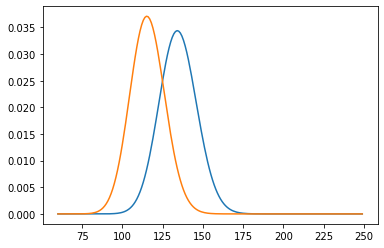

In [75]:
home, away = 'Perth Scorchers', 'Melbourne Renegades'
s_home, s_away = get_predicted_scores(home, away)
#t_home = sorted(home_runs[home])
t_home = list(range(60, 250))
p_home = poisson.pmf(t_home, s_home)
plt.plot(t_home, p_home)
#t_away = sorted(away_runs[away])
t_away = list(range(60, 250))
p_away = poisson.pmf(t_away, s_away)
plt.plot(t_away, p_away)
plt.show()

The above chart is nice and similar (makes sense!)

What we'd expect is that multiplying these together, returning our probability matrix, should result in a relatively even distributino - a straight(ish) line. Although since there is a theoretical max score of 720 per innings, we'd expect that our probabilities themselves are quite small (e.g. 148 to 122 should produce a small number!).

Note: due to a limitation in the charting library, the indices are 0-len(indices). In this case, just look up the index of the score to find where that match up is on the matrix. Since we're just using this for demonstration purposes, we aren't too fussed.

Also note that we can only use historical scores of the team and are limited by the youngness of the WBBL (as of this writing the WBBL has only hosted 210 matches, whereas the IPL has hosted 765). When each team has played hundreds of matches we can track the performance of each team much better (and end up with a much bigger matrix!)

In [76]:
prob_table = np.array([(i*j) for i, j in product(p_home, p_away)])
prob_table.shape = (len(p_home), len(p_away))
prob_df = pd.DataFrame(prob_table, index=t_home, columns=t_away)

cm = sns.light_palette("blue", as_cmap=True)

prob_df2=prob_df.style.background_gradient(cmap=cm)
display(prob_df2)


In [78]:
row, col = max(prob_df.idxmax(axis=0)), max(prob_df.idxmax(axis=1))
probability = prob_df.loc[row,col] * 100
print(row, col, probability)

134 115 0.12756496323117655


As seen above, our suspicions were correct - matchups between teams are pretty even, and the odds of the score being a blowout are vanishingly small (at least in terms of the total runs scored, not accounting for technical wins e.g. wickets).


In [79]:
teams

{'Adelaide Strikers',
 'Brisbane Heat',
 'Hobart Hurricanes',
 'Melbourne Renegades',
 'Melbourne Stars',
 'Perth Scorchers',
 'Sydney Sixers',
 'Sydney Thunder'}

In [92]:
table = [
    [t, get_home_offence(t), get_away_defence(t), get_away_offence(t), get_home_defence(t)]
    for t
    in teams
]

display(HTML(tabulate.tabulate(table, headers = ['Team Name', 'Home Offence', 'Away Defence', 'Away Offence', 'Home Defence'], tablefmt='html')))